Name | Matr.Nr. | Due Date
:--- | ---: | ---:
Oleg Bushtyrkov | k12338089 | 15.04.2024, 10:00

<h1 style="color:rgb(0,120,170)">Hands-on AI II</h1>
<h2 style="color:rgb(0,120,170)">Unit 2 &ndash; The Vanishing Gradient Problem (Assignment)</h2>

<b>Authors:</b> B. Schäfl, S. Lehner, J. Brandstetter, A. Schörgenhumer, R. Dangl<br>
<b>Date:</b> 05-03-2024

This file is part of the "Hands-on AI II" lecture material. The following copyright statement applies to all code within this file.

<b>Copyright statement:</b><br>
This material, no matter whether in printed or electronic form, may be used for personal and non-commercial educational use only. Any reproduction of this material, no matter whether as a whole or in parts, no matter whether in printed or in electronic form, requires explicit prior acceptance of the authors.

<h3 style="color:rgb(0,120,170)">How to use this notebook</h3>

This notebook is designed to run from start to finish. There are different tasks (displayed in <span style="color:rgb(248,138,36)">orange boxes</span>) which require your contribution (in form of code, plain text, ...). Most/All of the supplied functions are imported from the file <code>u2_utils.py</code> which can be seen and treated as a black box. However, for further understanding, you can look at the implementations of the helper functions. In order to run this notebook, the packages which are imported at the beginning of <code>u2_utils.py</code> need to be installed.

<div class="alert alert-warning">
    <b>Important:</b> Set the random seed with <code>u2.set_seed(17)</code> to enable reproducible results in all tasks that incorporate randomness (e.g., t-SNE, splitting data intro train and test sets, initializing weights of a neural network, running the model optimization with random batches, etc.). You must use <code>17</code> as seed.
</div>

In [1]:
# Import pre-defined utilities specific to this notebook.
import u2_utils as u2

# Import additional utilities needed in this notebook.
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch

from typing import Dict, Sequence

# Set default plotting style.
sns.set_theme()

# Setup Jupyter notebook (warning: this may affect all Jupyter notebooks running on the same Jupyter server).
u2.setup_jupyter()

# Check minimum versions.
u2.check_module_versions()

/home/olegbushtyrkov/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


Installed Python version: 3.10 (✓)
Installed numpy version: 1.26.4 (✓)
Installed pandas version: 2.2.1 (✓)
Installed PyTorch version: 2.1.1+cu121 (✓)
Installed scikit-learn version: 1.3.1 (✓)
Installed matplotlib version: 3.8.3 (✓)
Installed seaborn version: 0.13.0 (✓)


<h2>Definition of Auxiliaries</h2>

In this exercise, you will be working with a data set composed of 32x32 color images. It is a quite popular data set in the domain of machine learning: the <i>CIFAR10</i> data set. The data set distinguishes <i>ten</i> different classes, such as <i>airplane</i>, <i>cat</i>, etc. Here you can see an overview of the classes with some sample images:

<center>

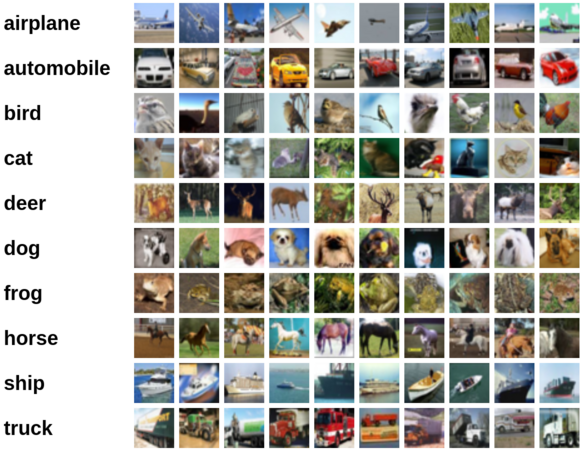

</center>

For curious minds, more information regarding this data set can be found at:

<center>
    <cite>Krizhevsky, A., 2009. Learning Multiple Layers of Features from Tiny Images. <a href="https://www.cs.toronto.edu/~kriz/learning-features-2009-TR.pdf>https://www.cs.toronto.edu/~kriz/learning-features-2009-TR.pdf</a>.</cite>
</center><br>
    
Before analyzing and tackling the vanishing gradient problem, the data set needs to be inspected.

<div class="alert alert-warning">
    <b>Exercise 1.1. [3 Points]</b>
    <ul>
        <li>Load the <i>CIFAR10</i> data set using the appropriate function as supplied by us.</li>
        <li>Split the data set into a training set and a test set in a ratio of $4:1$.</li>
        <li>Visualize the CIFAR10 training set in tabular form.</li>
    </ul>
</div>

In [2]:
# your code goes here
u2.set_seed(17)
cifar10 = u2.load_cifar10()
cifar10_train, cifar10_test = u2.split_data(cifar10, test_size=1.0 / 5.0)
cifar10_train

,a0,a1,a2,a3,a4,a5,a6,a7,a8,a9,...,a3063,a3064,a3065,a3066,a3067,a3068,a3069,a3070,a3071,digit
53669,65.0,75.0,63.0,59.0,59.0,99.0,122.0,85.0,99.0,45.0,...,222.0,238.0,238.0,249.0,242.0,231.0,203.0,112.0,50.0,5
12414,121.0,133.0,106.0,115.0,125.0,125.0,128.0,138.0,134.0,130.0,...,121.0,121.0,122.0,122.0,120.0,120.0,120.0,113.0,136.0,7
15864,117.0,125.0,136.0,147.0,149.0,151.0,133.0,130.0,144.0,158.0,...,185.0,187.0,185.0,175.0,146.0,155.0,148.0,114.0,82.0,8
36654,109.0,87.0,74.0,88.0,81.0,51.0,60.0,79.0,90.0,94.0,...,61.0,62.0,67.0,65.0,52.0,48.0,48.0,49.0,45.0,7
34902,253.0,249.0,250.0,251.0,251.0,250.0,249.0,242.0,233.0,226.0,...,187.0,187.0,174.0,166.0,189.0,220.0,238.0,252.0,255.0,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42297,147.0,163.0,150.0,175.0,177.0,174.0,172.0,176.0,163.0,183.0,...,103.0,94.0,87.0,99.0,84.0,105.0,77.0,118.0,98.0,4
33174,152.0,125.0,119.0,129.0,120.0,104.0,108.0,115.0,108.0,104.0,...,231.0,232.0,230.0,230.0,229.0,224.0,223.0,227.0,229.0,0
46470,80.0,79.0,79.0,80.0,80.0,81.0,81.0,83.0,83.0,85.0,...,192.0,192.0,192.0,191.0,191.0,191.0,191.0,190.0,190.0,8
34959,67.0,78.0,86.0,82.0,62.0,61.0,72.0,92.0,87.0,70.0,...,131.0,109.0,126.0,149.0,173.0,174.0,145.0,113.0,98.0,6


<div class="alert alert-warning">
    <b>Exercise 1.2. [3 Points]</b><br>
    Answer the following questions:
    <ul>
        <li>How many samples does the data set contain?</li>
        <li>How many samples does the training and the test set contain?</li>
        <li>How many features does the data set consist of (not counting the class label column <i>digit</i>)?</li>
    </ul>
</div>

60,000 samples  
Train: 48,000 samples  
Test: 12,000 samples  
Features: 3072

<div class="alert alert-warning">
    <b>Exercise 1.3. [6 Points]</b>
    <ul>
        <li>Reduce the dimensionality of the CIFAR10 training set using <i>t-SNE</i>. <br>To avoid long computation times and to get more informative features, select a subset of the training data with $n=3000$ samples and obtain recomputed features using the utility function <i>get_features_from_squeezenet</i> (use this new data set only here, for the other exercises use the training and test data sets you defined in exercise 1.2). Afterwards, apply t-SNE with $2$ components on this modified data (choose the perplexity yourself).</li>
        <li>Visualize the t-SNE downprojection.</li>
    </ul>
</div>

In [31]:
# your code goes here
u2.set_seed(17)
majority, cifar10_subset = u2.split_data(cifar10_train, test_size=1/16)
recomputed_features = u2.get_features_from_squeezenet(cifar10_subset)
cifar10_subset_tsne = u2.apply_tsne(n_components=2, data=cifar10_subset, perplexity=17)
u2.plot_points_2d(data=cifar10_subset_tsne, targets=recomputed_features[1], figsize=(14,7))

/home/olegbushtyrkov/JKU_HoAI2/materials_u2/u2_utils.py:242: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


ValueError: Image size of 1173x67068 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 1400x700 with 1 Axes>

<div class="alert alert-warning">
    <b>Exercise 1.4. [2 Points]</b>
    <ul>
        <li>Comment on the separability of the CIFAR10 training (sub)set with respect to the downprojection.</li>
    </ul>
</div>

your answer goes here

<h2>Training of a Neural Network</h2>

Loading and inspecting a new data set is always an exciting moment, but even more exciting is the implementation of a corresponding neural network and applying it to said data set. In this section, you will thus have to implement and train an appropriate neural network model and revisit your knowledge about the <i>forward</i> as well as the <i>backward</i> pass.

<div class="alert alert-warning">
    <b>Important:</b> The following code snippet is taken from the accompanying exercise notebook. Do not modify this code here.
</div>

In [4]:
def train_and_evaluate(model: torch.nn.Module, optimizer: torch.optim.Optimizer, num_epochs: int,
                       loader_train: torch.utils.data.DataLoader, loader_test: torch.utils.data.DataLoader,
                       device: torch.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')) -> None:
    """
    Auxiliary function for training and evaluating a corresponding model.
    
    :param model: model instance to train and evaluate
    :param optimizer: optimizer to use for model training
    :param num_epochs: amount of epochs for model training
    :param loader_train: data loader supplying the training samples
    :param loader_test: data loader supplying the test samples
    :param device: device to use for model training and evaluation
    """
    model.to(device)
    
    for epoch in range(num_epochs):
        # Train model instance for one epoch.
        u2.train_network(
            model=model,
            data_loader=loader_train,
            device=device,
            optimizer=optimizer
        )

        # Evaluate current model instance.
        performance = u2.test_network(
            model=model,
            data_loader=loader_train,
            device=device
        )

        # Print result of current epoch to standard out.
        print(f'Epoch: {str(epoch + 1).zfill(len(str(num_epochs)))} ' +
              f'/ Train loss: {performance[0]:.4f} / Train accuracy: {performance[1]:.4f}')

    # Evaluate final model on test data set.
    performance = u2.test_network(model=model, data_loader=loader_test, device=device)
    print(f'\nTest loss: {performance[0]:.4f} / Test accuracy: {performance[1]:.4f}')

<div class="alert alert-warning">
    <b>Exercise 2.1. [4 Points]</b>
    <ul>
        <li>Create a corresponding <code>TensorDataset</code> for the training as well as the test set.</li>
        <li>Wrap the previously defined <code>TensorDataset</code> instances in separate <code>DataLoader</code> instances with a batch size of $80$ (shuffle the training data set).</li>
        <li>Scale the features of the training as well as test set by a factor of $\frac{1}{255}$, i.e., normalize the data to range $[0; 1]$</li>
    </ul>
</div>

In [33]:
# your code goes here
loader_cifar10_train = torch.utils.data.DataLoader(
    dataset=torch.utils.data.TensorDataset(
        torch.from_numpy(cifar10_train.drop(columns=['digit']).values / 255),  # normalize to range [0; 1]
        torch.from_numpy(cifar10_train['digit'].values)
    ),
    batch_size=80,
    shuffle=True
)

loader_cifar10_test = torch.utils.data.DataLoader(
    dataset=torch.utils.data.TensorDataset(
        torch.from_numpy(cifar10_test.drop(columns=['digit']).values / 255),  # normalize to range [0; 1]
        torch.from_numpy(cifar10_test['digit'].values)
    ),
    batch_size=80,
    shuffle=False
)

<div class="alert alert-warning">
    <b>Exercise 2.2. [6 Points]</b>
    <ul>
        <li>Implement a class <code>FNN_0</code> with the following architecture (square weight matrix means that the input size is equal to the output size):</li>
    </ul>
    <table style="text-align:center;vertical-align:middle">
        <th>Position</th>
        <th>Element</th>
        <th>Comment</th>
        <tr>
            <td>0</td>
            <td>input</td>
            <td>input size = $32\times{}32\times{}3 = 3072$</td>
        </tr>
        <tr>
            <td>1</td>
            <td>fully connected</td>
            <td>$1024$ output features</td>
        </tr>
        <tr>
            <td>2</td>
            <td>sigmoid</td>
            <td>-</td>
        </tr>
        <tr>
            <td>3</td>
            <td>fully connected</td>
            <td>square weight matrix</td>
        </tr>
        <tr>
            <td>4</td>
            <td>sigmoid</td>
            <td>-</td>
        </tr>
        <tr>
            <td>5</td>
            <td>fully connected</td>
            <td>square weight matrix</td>
        </tr>
        <tr>
            <td>6</td>
            <td>sigmoid</td>
            <td>-</td>
        </tr>
        <tr>
            <td>7</td>
            <td>fully connected</td>
            <td>square weight matrix</td>
        </tr>
        <tr>
            <td>8</td>
            <td>sigmoid</td>
            <td>-</td>
        </tr>
        <tr>
            <td>9</td>
            <td>fully connected</td>
            <td>square weight matrix</td>
        </tr>
        <tr>
            <td>10</td>
            <td>sigmoid</td>
            <td>-</td>
        </tr>
        <tr>
            <td>11</td>
            <td>fully connected</td>
            <td>$10$ output features</td>
        </tr>
    </table>
</div>

In [40]:
# your code goes here
class FNN_0(torch.nn.Module):
    
    def __init__(self):
        super().__init__()
        self.fc1 = torch.nn.Linear(32*32*3, 1024)
        self.sig1 = torch.nn.Sigmoid()
        self.fc2 = torch.nn.Linear(1024, 1024)
        self.sig2 = torch.nn.Sigmoid()
        self.fc3 = torch.nn.Linear(1024, 1024)
        self.sig3 = torch.nn.Sigmoid()
        self.fc4 = torch.nn.Linear(1024, 1024)
        self.sig4 = torch.nn.Sigmoid()
        self.fc5 = torch.nn.Linear(1024, 1024)
        self.sig5 = torch.nn.Sigmoid()
        self.fc6 = torch.nn.Linear(1024, 10)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.fc1(x)
        x = self.sig1(x)
        x = self.fc2(x)
        x = self.sig2(x)
        x = self.fc3(x)
        x = self.sig3(x)
        x = self.fc4(x)
        x = self.sig4(x)
        x = self.fc5(x)
        x = self.sig5(x)
        return self.fc6(x)

<div class="alert alert-warning">
    <b>Exercise 2.3. [3 Points]</b>
    <ul>
        <li>Create an instance of <code>FNN_0</code> as well as of a corresponding <code>SGD</code> optimizer with a learning rate of $0.05$.</li>
        <li>Print the resulting model and verify the architecture by inspecting the output.</li>
    </ul>
</div>

In [41]:
# your code goes here
u2.set_seed(17)
fnn_0 = FNN_0()
optimizer = torch.optim.SGD(fnn_0.parameters(), lr=0.05)
print(fnn_0)

FNN_0(
  (fc1): Linear(in_features=3072, out_features=1024, bias=True)
  (sig1): Sigmoid()
  (fc2): Linear(in_features=1024, out_features=1024, bias=True)
  (sig2): Sigmoid()
  (fc3): Linear(in_features=1024, out_features=1024, bias=True)
  (sig3): Sigmoid()
  (fc4): Linear(in_features=1024, out_features=1024, bias=True)
  (sig4): Sigmoid()
  (fc5): Linear(in_features=1024, out_features=1024, bias=True)
  (sig5): Sigmoid()
  (fc6): Linear(in_features=1024, out_features=10, bias=True)
)


<div class="alert alert-warning">
    <b>Exercise 2.4. [2 Points]</b>
    <ul>
        <li>Train an <code>FNN_0</code> network for $6$ epochs, print the training accuracy as well as the loss per epoch and report the final test set loss and accuracy.</li>
    </ul>
</div>

In [42]:
# your code goes here
u2.set_seed(17)

train_and_evaluate(
    model=fnn_0,
    optimizer=optimizer,
    num_epochs=6,
    loader_train=loader_cifar10_train,
    loader_test=loader_cifar10_test
)

Epoch: 1 / Train loss: 0.0293 / Train accuracy: 0.0999
Epoch: 2 / Train loss: 0.0290 / Train accuracy: 0.1001
Epoch: 3 / Train loss: 0.0289 / Train accuracy: 0.1006
Epoch: 4 / Train loss: 0.0289 / Train accuracy: 0.1004
Epoch: 5 / Train loss: 0.0289 / Train accuracy: 0.1006
Epoch: 6 / Train loss: 0.0288 / Train accuracy: 0.0999

Test loss: 0.0288 / Test accuracy: 0.1003


<div class="alert alert-warning">
    <b>Exercise 2.5. [2 Points]</b>
    <ul>
        <li>What do you observe?</li>
    </ul>
</div>

The Train loss and Test loss, as well as the Accuracies are very similar by the 6th epoch.  
However, there is an overall low increase in accuracy throughout the training process, and by the end of the 6th epoch, the train accuracy is back to where it was in the 1st epoch.

<div class="alert alert-warning">
    <b>Exercise 2.6. [3 Points]</b>
    <ul>
        <li>Write down a formula for the corresponding <i>forward</i> pass of <code>FNN_0</code>. Use the same notation as presented during the exercise.</li>
    </ul>
</div>

<center>
    \begin{equation}
        \hat{y} = g\left(h^{(5)}(h^{(4)}(h^{(3)}(h^{(2)}(h^{(1)}(\mathbf{x};\mathbf{W}_1);\mathbf{W}_2);\mathbf{W}_3);\mathbf{W}_4);\mathbf{W}_5);\mathbf{W}_6) \right )
    \end{equation}
</center>

<div class="alert alert-warning">
    <b>Exercise 2.7. [4 Points]</b>
    <ul>
        <li>Write down a formula for the corresponding <i>backward</i> pass of <code>FNN_0</code>. Use the same notation as presented during the exercise.</li>
    </ul>
</div>

<center>
    \begin{align*}
        \mathbf{W}_6 & \leftarrow \mathbf{W}_6 - \eta \frac{\partial L}{\partial \mathbf{W}_6} \\
        \mathbf{W}_5 & \leftarrow \mathbf{W}_5 - \eta \frac{\partial L}{\partial h^{(5)}}\frac{\partial h^{(5)}}{\partial \mathbf{W}_5} \\
        \mathbf{W}_4 & \leftarrow \mathbf{W}_4 - \eta \frac{\partial L}{\partial h^{(5)}}\frac{\partial h^{(5)}}{\partial h^{(4)}}\frac{\partial h^{(4)}}{\partial \mathbf{W}_4} \\
        \mathbf{W}_3 & \leftarrow \mathbf{W}_3 - \eta \frac{\partial L}{\partial h^{(5)}}\frac{\partial h^{(5)}}{\partial h^{(4)}}\frac{\partial h^{(4)}}{\partial h^{(3)}}\frac{\partial h^{(3)}}{\partial \mathbf{W}_3} \\
        \mathbf{W}_2 & \leftarrow \mathbf{W}_2 - \eta \frac{\partial L}{\partial h^{(5)}}\frac{\partial h^{(5)}}{\partial h^{(4)}}\frac{\partial h^{(4)}}{\partial h^{(3)}}\frac{\partial h^{(3)}}{\partial h^{(2)}}\frac{\partial h^{(2)}}{\partial \mathbf{W}_2} \\
        \mathbf{W}_1 & \leftarrow \mathbf{W}_1 - \eta \frac{\partial L}{\partial h^{(5)}}\frac{\partial h^{(5)}}{\partial h^{(4)}}\frac{\partial h^{(4)}}{\partial h^{(3)}}\frac{\partial h^{(3)}}{\partial h^{(2)}}\frac{\partial h^{(2)}}{\partial h^{(1)}}\frac{\partial h^{(1)}}{\partial \mathbf{W}_1} \\
    \end{align*}
</center>

<h2>Analyzing Gradients</h2>

Is the performance problem of <code>FNN_0</code> related to the vanishing gradient problem? This is exactly the point you're going to figure out in this exercise. As a first step, the gradients of a freshly initialized model need to be collected and analyzed. Afterwards, in case of a vanishing gradient problem, countermeasures must be taken.</p>

<div class="alert alert-warning">
    <b>Important:</b> The following code snippet is taken from the accompanying exercise notebook. Do not modify this code here.
</div>

In [43]:
def collect_gradients(model: torch.nn.Module, loader: torch.utils.data.DataLoader,
                      device: torch.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')) -> Sequence[Dict[str, np.array]]:
    """
    Auxiliary function for collecting gradients of a corresponding model.
    
    :param model: model instance to be used for collecting gradients
    :param loader: data loader supplying the samples used for collecting gradients
    :param device: device to use for gradient collection
    :return: sequence of parameter names and gradients, averaged over all parameter elements
    """
    model.to(device)
    model_state = model.training
    model.train()
    model.zero_grad()
    
    # Iterating over the data set and computing the corresponding gradients.
    # Since we are only interested in the gradients, we can skip the optimization step.
    gradients = {}
    criterion = torch.nn.CrossEntropyLoss()
    
    for data, target in loader:
        data, target = data.float().to(device), target.long().to(device)
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
    
        # Collecting the (averaged absolute) gradients from the current model.
        for name, parameter in model.named_parameters():
            if "weight" in name and parameter.grad is not None:
                gradients.setdefault(name, []).append(parameter.grad.view(-1).abs().mean().item())
        model.zero_grad()
    
    # Reset model state and return collected gradients.
    model.train(mode=model_state)
    return gradients

<div class="alert alert-warning">
    <b>Exercise 3.1. [3 Points]</b>
    <ul>
        <li>Create a <i>fresh</i> instance of <code>FNN_0</code> and collect its gradients using the CIFAR10 training set.</li>
    </ul>
</div>

In [45]:
# your code goes here
gradients = []
fnn_01 = FNN_0()
gradients.append((fnn_01,collect_gradients(model=fnn_01, loader=loader_cifar10_train)))

<div class="alert alert-warning">
    <b>Exercise 3.2. [3 Points]</b>
    <ul>
        <li>Visualize the gradients of each weight parameter accordingly.</li>
    </ul>
</div>

/home/olegbushtyrkov/.local/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/olegbushtyrkov/.local/lib/python3.10/site-packages/seaborn/categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/home/olegbushtyrkov/.local/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/olegbushtyrkov/.local/lib/python3.10/site-packages/seaborn/categorical.py:632: FutureWarning: Se

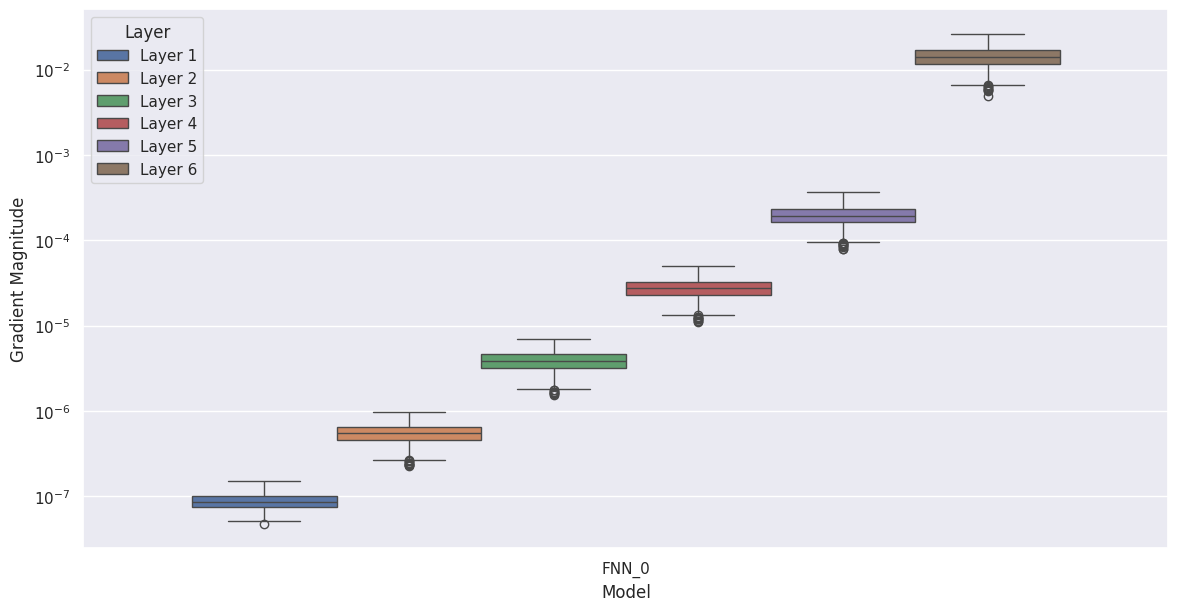

In [46]:
# your code goes here
gradient_dfs = []
for model, gradient in gradients:
    gradient_data = pd.DataFrame(gradient)
    gradient_data.columns = [f"Layer {i + 1}" for i in range(len(gradient))]
    gradient_data = pd.melt(gradient_data, var_name="Layer", value_name="Gradient Magnitude")
    gradient_data["Model"] = type(model).__name__
    gradient_dfs.append(gradient_data)

# Combine all gradients in a single data frame.
gradients_df = pd.concat(gradient_dfs)

# Define plotting figure and corresponding attributes.
fig, ax = plt.subplots(figsize=(14, 7))
ax.set(yscale='log')

# Plot pre-processed gradients.
sns.boxplot(x='Model', y='Gradient Magnitude', hue='Layer', data=gradients_df, ax=ax)
plt.show()

<div class="alert alert-warning">
    <b>Exercise 3.3. [2 Points]</b>
    <ul>
        <li>What do you observe?</li>
    </ul>
</div>

We can see that the loss of each layer decreases the deeper into the model we go.  
As such the Vanishing Gradient Problem has emerged in our model!!

<div class="alert alert-warning">
    <b>Exercise 3.4. [6 Points]</b>
    <ul>
        <li>Assume a vanishing gradient. Apply the countermeasure presented during the accompanying exercise by implementing a corresponding <code>FNN_1</code> network.</li>
    </ul>
</div>

In [50]:
# your code goes here
class FNN_1(torch.nn.Module):
    
    def __init__(self):
        super().__init__()
        self.fc1 = torch.nn.Linear(32*32*3, 1024)
        self.relu1 = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(1024, 1024)
        self.relu2 = torch.nn.ReLU()
        self.fc3 = torch.nn.Linear(1024, 1024)
        self.relu3 = torch.nn.ReLU()
        self.fc4 = torch.nn.Linear(1024, 1024)
        self.relu4 = torch.nn.ReLU()
        self.fc5 = torch.nn.Linear(1024, 1024)
        self.relu5 = torch.nn.ReLU()
        self.fc6 = torch.nn.Linear(1024, 10)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        x = self.relu3(x)
        x = self.fc4(x)
        x = self.relu4(x)
        x = self.fc5(x)
        x = self.relu5(x)
        return self.fc6(x)

<div class="alert alert-warning">
    <b>Exercise 3.5. [3 Points]</b>
    <ul>
        <li>Create an instance of <code>FNN_1</code> as well as of a corresponding <code>SGD</code> optimizer with a learning rate of $0.05$.</li>
        <li>Print the resulting model and verify the architecture by inspecting the output.</li>
    </ul>
</div>

In [48]:
# your code goes here
u2.set_seed(17)
fnn_1 = FNN_1()
optimizer = torch.optim.SGD(fnn_1.parameters(), lr=0.05)
print(fnn_1)

FNN_1(
  (fc1): Linear(in_features=3072, out_features=1024, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=1024, out_features=1024, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=1024, out_features=1024, bias=True)
  (relu3): ReLU()
  (fc4): Linear(in_features=1024, out_features=1024, bias=True)
  (relu4): ReLU()
  (fc5): Linear(in_features=1024, out_features=1024, bias=True)
  (relu5): ReLU()
  (fc6): Linear(in_features=1024, out_features=10, bias=True)
)


<div class="alert alert-warning">
    <b>Exercise 3.6. [3 Points]</b>
    <ul>
        <li>Train an <code>FNN_1</code> network for $6$ epochs, print the training accuracy as well as the loss per epoch and report the final test set loss and accuracy.</li>
    </ul>
</div>

In [49]:
# your code goes here
u2.set_seed(17)

train_and_evaluate(
    model=fnn_1,
    optimizer=optimizer,
    num_epochs=6,
    loader_train=loader_cifar10_train,
    loader_test=loader_cifar10_test
)

Epoch: 1 / Train loss: 0.0263 / Train accuracy: 0.1958
Epoch: 2 / Train loss: 0.0239 / Train accuracy: 0.2944
Epoch: 3 / Train loss: 0.0221 / Train accuracy: 0.3637
Epoch: 4 / Train loss: 0.0209 / Train accuracy: 0.3953
Epoch: 5 / Train loss: 0.0210 / Train accuracy: 0.3999
Epoch: 6 / Train loss: 0.0196 / Train accuracy: 0.4344

Test loss: 0.0200 / Test accuracy: 0.4231


<div class="alert alert-warning">
    <b>Exercise 3.7. [2 Points]</b>
    <ul>
        <li>What do you observe?</li>
    </ul>
</div>

The Vanishing Gradient Problem has been circumvented, so that the accuracy increases by a noticible amount!

<div class="alert alert-warning">
    <b>Exercise 3.8. [3 Points]</b>
    <ul>
        <li>Create a <i>fresh</i> instance of <code>FNN_1</code> and collect its gradients using the CIFAR10 training set.</li>
    </ul>
</div>

In [53]:
# your code goes here
models = []
for model_class in [FNN_0, FNN_1]:
    # Set random seed for reproducibility.
    u2.set_seed(17)
    
    # Create logistic regression models.
    models.append(model_class())

gradients = [(model, collect_gradients(model=model, loader=loader_cifar10_train)) for model in models]

<div class="alert alert-warning">
    <b>Exercise 3.9. [3 Points]</b>
    <ul>
        <li>Visualize the gradients of each weight parameter accordingly. Include the gradient visualization of <code>FNN_0</code> to enable a direct comparison.</li>
    </ul>
</div>

/home/olegbushtyrkov/.local/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/olegbushtyrkov/.local/lib/python3.10/site-packages/seaborn/categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/home/olegbushtyrkov/.local/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/olegbushtyrkov/.local/lib/python3.10/site-packages/seaborn/categorical.py:632: FutureWarning: Se

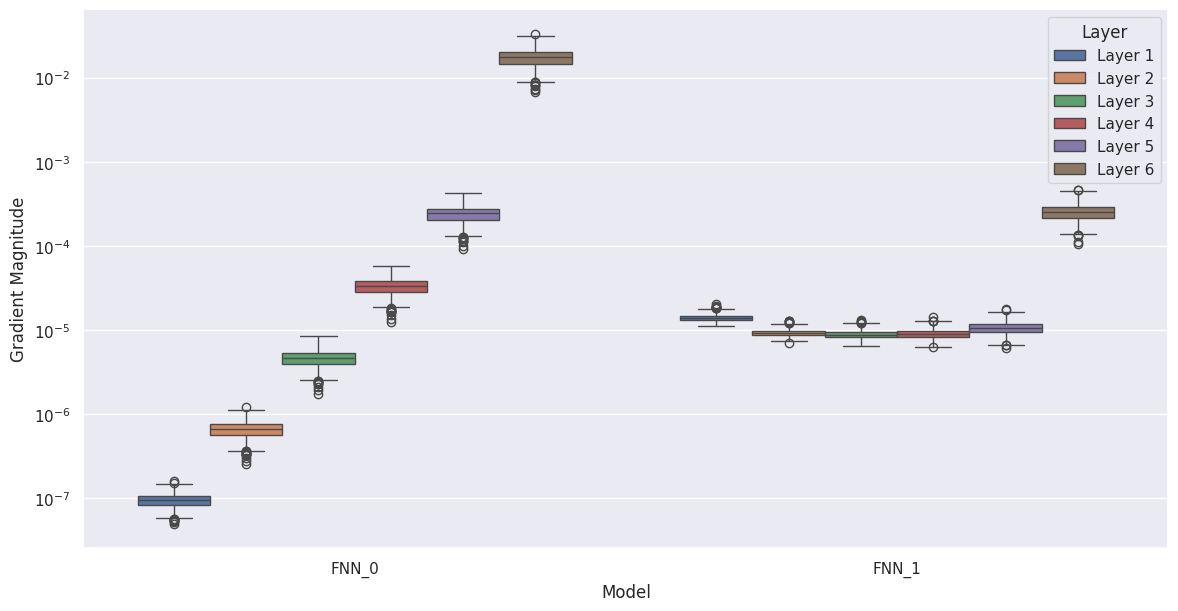

In [54]:
# your code goes here
gradient_dfs = []
for model, gradient in gradients:
    gradient_data = pd.DataFrame(gradient)
    gradient_data.columns = [f"Layer {i + 1}" for i in range(len(gradient))]
    gradient_data = pd.melt(gradient_data, var_name="Layer", value_name="Gradient Magnitude")
    gradient_data["Model"] = type(model).__name__
    gradient_dfs.append(gradient_data)

# Combine all gradients in a single data frame.
gradients_df = pd.concat(gradient_dfs)

# Define plotting figure and corresponding attributes.
fig, ax = plt.subplots(figsize=(14, 7))
ax.set(yscale='log')

# Plot pre-processed gradients.
sns.boxplot(x='Model', y='Gradient Magnitude', hue='Layer', data=gradients_df, ax=ax)
plt.show()

<div class="alert alert-warning">
    <b>Exercise 3.10. [2 Points]</b>
    <ul>
        <li>What do you observe?</li>
    </ul>
</div>

FNN_1 retains the loss better than FNN_0 the deeper we go through the model!

<div class="alert alert-warning">
    <b>Exercise 3.11. [2 Points]</b>
    <ul>
        <li>Given the results above, what do you think about the model we have now created? Does it perform well (enough)?  In any case, state your reasoning.</li>
    </ul>
</div>

I think it does! Since it maintains its loss throughout the layers, there is less vanishing of the gradient.  
FNN_1 also results in better Test accuracy, as seen in Ex.6. Therefore there is a greater chance for it to label an image correctly!

<h2>Deriving Derivatives</h2>

It is already known from the lecture as well as the exercise that <i>activation</i> functions are the primary culprit of the <i>Vanishing Gradient Problem</i>. Hence, it is important to know <i>how</i> the chosen activation functions activate the input and consequently what the <i>derivative</i> is.

<div class="alert alert-warning">
    <b>Exercise 4.1. [4 Points]</b><br>
    Take a look at the official <a href="https://pytorch.org/docs/stable/generated/torch.nn.Hardsigmoid.html#torch.nn.Hardsigmoid">PyTorch documentation</a> to solve the following tasks:
    <ul>
        <li>Implement the <code>hardsigmoid</code> activation function as it was done for <code>relu</code> in the exercise.</li>
        <li>Implement the <i>derivative</i> of the <code>hardsigmoid</code> activation function accordingly.</li>
    </ul>
</div>

In [55]:
# your code goes here
def hardsigmoid(x: float):
    if x <= -3:
        return 0
    elif x >= 3:
        return 1
    else:
        return x/6 + 1/2

def hardsigmoid_d(x: float):
    if x <= -3 or x >= 3:
        return 0
    else:
        return 1/6

<div class="alert alert-warning">
    <b>Exercise 4.2. [3 Points]</b>
    <ul>
        <li>Find $5$ different inputs showing the <i>value range</i> of the <code>hardsigmoid</code> activation function as well as its derivative.</li>
        <li>Plot the <code>hardsigmoid</code> activation function including its derivative for the input range $[-8; 8]$.</li>
    </ul>
</div>

hardsigmoid( -6.0):  0.0000 | hardsigmoid'( -6.0): 0.0000
hardsigmoid( -2.0):  0.1667 | hardsigmoid'( -2.0): 0.1667
hardsigmoid(  0.0):  0.5000 | hardsigmoid'(  0.0): 0.1667
hardsigmoid(  2.0):  0.8333 | hardsigmoid'(  2.0): 0.1667
hardsigmoid(  6.0):  1.0000 | hardsigmoid'(  6.0): 0.0000


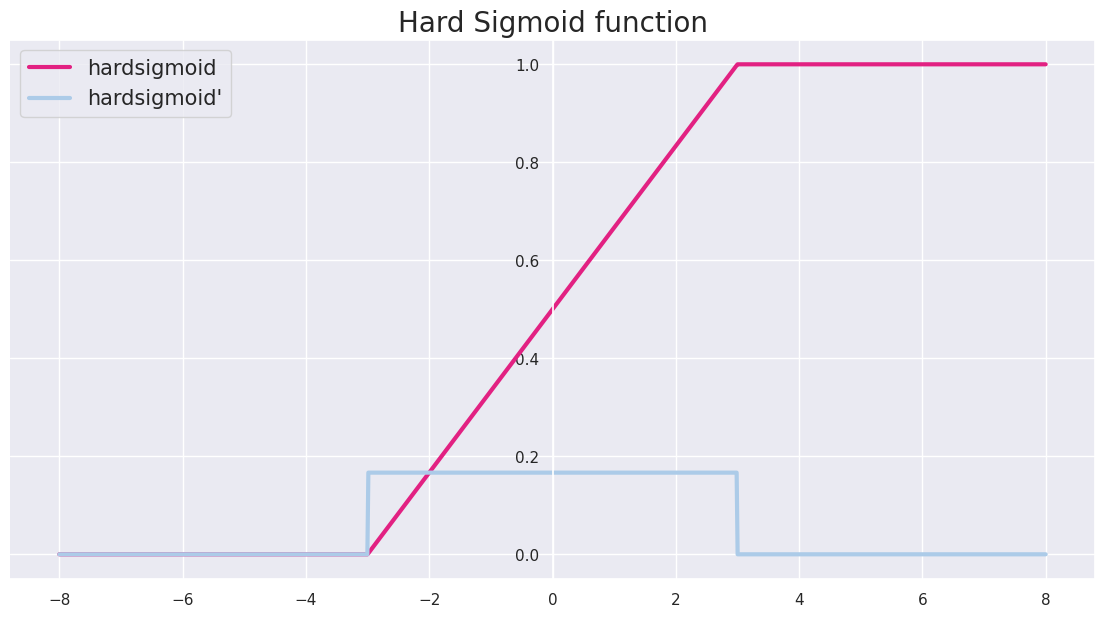

In [67]:
# your code goes here
for x in [-6.0, -2.0, 0.0, 2.0, 6.0]:
    print(f'hardsigmoid({x:>5}): {hardsigmoid(x):7.4f} | hardsigmoid\'({x:>5}): {hardsigmoid_d(x):.4f}')

def plot_hardsigmoid_with_derivative(x_min: float = -8.0, x_max: float = 8.0, granularity: int = 1000) -> None:
    """
    Plot the rectified linear unit function including its derivative.
    
    :param x_min: minimum value of the input value range
    :param x_max: maximum value of the input value range
    :param granularity: granularity controlling the stepsize of the input value range
    """
    data = np.linspace(x_min, x_max, granularity)
    data_pivot_neg = np.where(data <= 0)
    data_pivot_pos = np.where(data > 0)

    fig, ax = plt.subplots(figsize=(14, 7))
    ax.spines['left'].set_position('center')

    plt.plot(data, tuple(map(hardsigmoid, data)), color='#e22182', linewidth=3, label='hardsigmoid')
    # Plot derivative of negative/positive data separately to avoid a linked line plot.
    if len(data_pivot_neg) > 0:
        data_neg = data[data_pivot_neg]
        plt.plot(data_neg, tuple(map(hardsigmoid_d, data_neg)), color='#accbe8', linewidth=3, label="hardsigmoid'")
    if len(data_pivot_pos) > 0:
        data_pos = data[data_pivot_pos]
        plt.plot(data_pos, tuple(map(hardsigmoid_d, data_pos)), color='#accbe8', linewidth=3)
    plt.title('Hard Sigmoid function', fontsize=20)
    plt.legend(prop={'size': 15})
    plt.show()

# Plot rectified linear unit function including its derivative.
plot_hardsigmoid_with_derivative()

<div class="alert alert-warning">
    <b>Exercise 4.3. [4 Points]</b><br>
    Take a look at the official <a href="https://pytorch.org/docs/stable/generated/torch.nn.LeakyReLU.html#torch.nn.LeakyReLU">PyTorch documentation</a> to solve the following tasks:
    <ul>
        <li>Implement the <code>leaky_relu</code> activation function as it was done for <code>relu</code> in the exercise. Use a <i>negative slope</i> of $0.25$.</li>
        <li>Implement the <i>derivative</i> of the <code>leaky_relu</code> activation function accordingly.</li>
    </ul>
</div>

In [59]:
# your code goes here
def leaky_relu(x: float):
    
    return max(0.0, x) + 0.25*min(0.0, x)

def leaky_relu_d(x: float):
    
    return 1 if x>=0 else 0.25

<div class="alert alert-warning">
    <b>Exercise 4.4. [3 Points]</b>
    <ul>
        <li>Find $5$ different inputs showing the <i>value range</i> of the <code>leaky_relu</code> activation function as well as its derivative.</li>
        <li>Plot the <code>leaky_relu</code> activation function including its derivative for the input range $[-8; 8]$.</li>
    </ul>
</div>

leaky_relu( -6.0): -1.5000 | leaky_relu'( -6.0): 0.2500
leaky_relu( -2.0): -0.5000 | leaky_relu'( -2.0): 0.2500
leaky_relu(  0.0):  0.0000 | leaky_relu'(  0.0): 1.0000
leaky_relu(  2.0):  2.0000 | leaky_relu'(  2.0): 1.0000
leaky_relu(  6.0):  6.0000 | leaky_relu'(  6.0): 1.0000


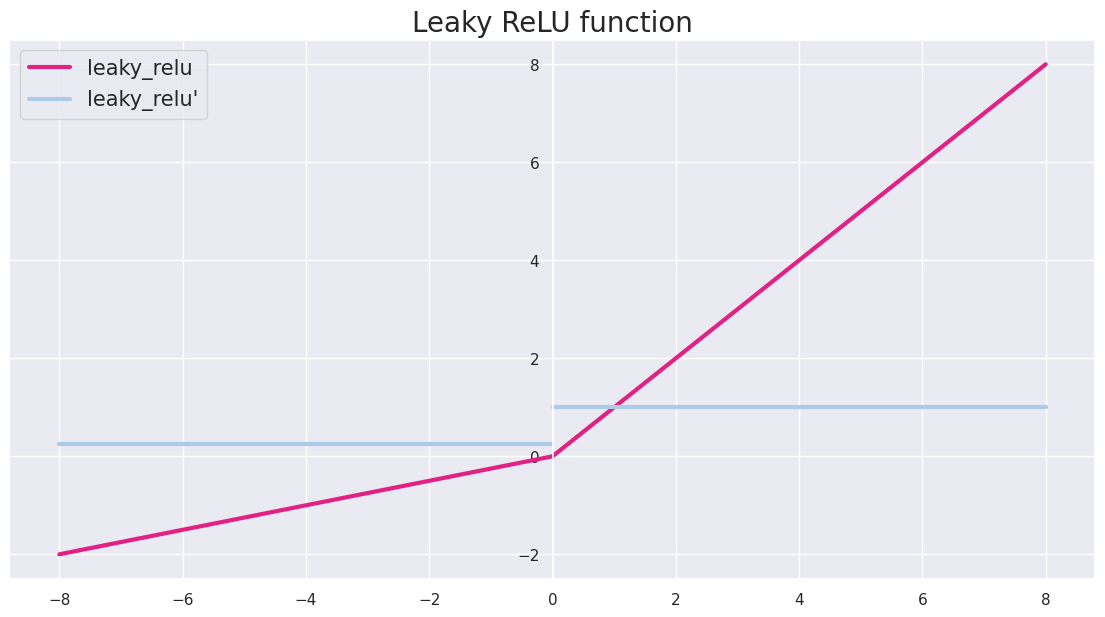

In [66]:
# your code goes here
for x in [-6.0, -2.0, 0.0, 2.0, 6.0]:
    print(f'leaky_relu({x:>5}): {leaky_relu(x):7.4f} | leaky_relu\'({x:>5}): {leaky_relu_d(x):.4f}')

def plot_leaky_relu_with_derivative(x_min: float = -8.0, x_max: float = 8.0, granularity: int = 1000) -> None:
    """
    Plot the rectified linear unit function including its derivative.
    
    :param x_min: minimum value of the input value range
    :param x_max: maximum value of the input value range
    :param granularity: granularity controlling the stepsize of the input value range
    """
    data = np.linspace(x_min, x_max, granularity)
    data_pivot_neg = np.where(data <= 0)
    data_pivot_pos = np.where(data > 0)

    fig, ax = plt.subplots(figsize=(14, 7))
    ax.spines['left'].set_position('center')

    plt.plot(data, tuple(map(leaky_relu, data)), color='#e22182', linewidth=3, label='leaky_relu')
    # Plot derivative of negative/positive data separately to avoid a linked line plot.
    if len(data_pivot_neg) > 0:
        data_neg = data[data_pivot_neg]
        plt.plot(data_neg, tuple(map(leaky_relu_d, data_neg)), color='#accbe8', linewidth=3, label="leaky_relu'")
    if len(data_pivot_pos) > 0:
        data_pos = data[data_pivot_pos]
        plt.plot(data_pos, tuple(map(leaky_relu_d, data_pos)), color='#accbe8', linewidth=3)
    plt.title('Leaky ReLU function', fontsize=20)
    plt.legend(prop={'size': 15})
    plt.show()

# Plot rectified linear unit function including its derivative.
plot_leaky_relu_with_derivative()

<div class="alert alert-warning">
    <b>Exercise 4.5. [2 Points]</b>
    <ul>
        <li>Which of these two activation functions from above do you think is susceptible to the vanishing gradient problem? Explain your decision.</li>
    </ul>
</div>

I would say that the hard sigmoid function is susceptible, as any values greater than 3 are droped to 0, 
    which means that subsequent layers would receive next to no error to adapt the parameters accordingly.

<div class="alert alert-warning">
    <b>Exercise 4.6. [6 Points]</b>
    <ul>
        <li>Create the same network architecture as <code>FNN_0</code> but replace its activation function with the one you selected above in <b>Exercise 4.5.</b> (the one that is susceptible to the vanishing gradient problem). Name the new network <code>FNN_2</code>.</li>
    </ul>
</div>

In [81]:
# your code goes here
class FNN_2(torch.nn.Module):
    
    def __init__(self):
        super().__init__()
        self.fc1 = torch.nn.Linear(32*32*3, 1024)
        #self.hsig1 = torch.nn.functional.hardsigmoid(x)
        self.fc2 = torch.nn.Linear(1024, 1024)
        #self.hsig2 = torch.nn.functional.hardsigmoid(x)
        self.fc3 = torch.nn.Linear(1024, 1024)
        #self.hsig3 = torch.nn.functional.hardsigmoid(x)
        self.fc4 = torch.nn.Linear(1024, 1024)
        #self.hsig4 = torch.nn.functional.hardsigmoid(x)
        self.fc5 = torch.nn.Linear(1024, 1024)
        #self.hsig5 = torch.nn.functional.hardsigmoid(x)
        self.fc6 = torch.nn.Linear(1024, 10)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.fc1(x)
        x = torch.nn.functional.hardsigmoid(x) #self.hsig1(x)
        x = self.fc2(x)
        x = torch.nn.functional.hardsigmoid(x) #self.hsig2(x)
        x = self.fc3(x)
        x = torch.nn.functional.hardsigmoid(x) #self.hsig3(x)
        x = self.fc4(x)
        x = torch.nn.functional.hardsigmoid(x) #self.hsig4(x)
        x = self.fc5(x)
        x = torch.nn.functional.hardsigmoid(x) #self.hsig5(x)
        return self.fc6(x)

<div class="alert alert-warning">
    <b>Exercise 4.7. [3 Points]</b>
    <ul>
        <li>Create a <i>fresh</i> instance of <code>FNN_2</code> and collect its gradients using the CIFAR10 training set.</li>
    </ul>
</div>

In [82]:
# your code goes here
gradients = []
fnn_2 = FNN_2()
gradients.append((fnn_2,collect_gradients(model=fnn_2, loader=loader_cifar10_train)))

<div class="alert alert-warning">
    <b>Exercise 4.8. [3 Points]</b>
    <ul>
        <li>Visualize the gradients of each weight parameter accordingly. Include the gradient visualization of <code>FNN_0</code> to enable a direct comparison.</li>
    </ul>
</div>

/home/olegbushtyrkov/.local/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/olegbushtyrkov/.local/lib/python3.10/site-packages/seaborn/categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/home/olegbushtyrkov/.local/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/olegbushtyrkov/.local/lib/python3.10/site-packages/seaborn/categorical.py:632: FutureWarning: Se

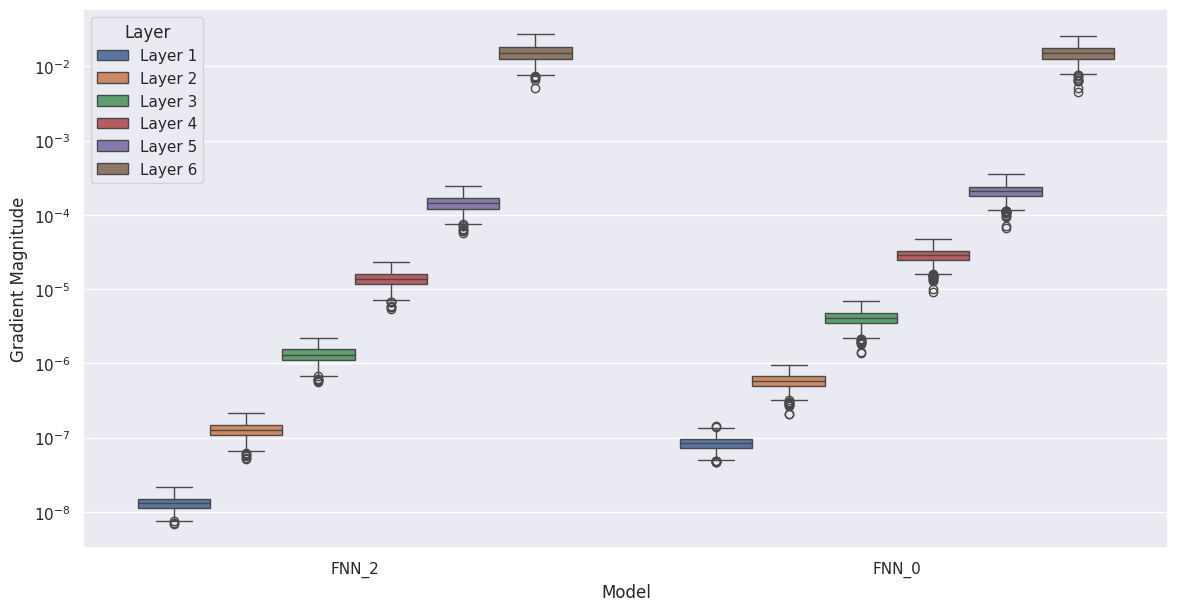

In [83]:
# your code goes here
fnn_02 = FNN_0()
gradients.append((fnn_02,collect_gradients(model=fnn_02, loader=loader_cifar10_train)))

gradient_dfs = []
for model, gradient in gradients:
    gradient_data = pd.DataFrame(gradient)
    gradient_data.columns = [f"Layer {i + 1}" for i in range(len(gradient))]
    gradient_data = pd.melt(gradient_data, var_name="Layer", value_name="Gradient Magnitude")
    gradient_data["Model"] = type(model).__name__
    gradient_dfs.append(gradient_data)

# Combine all gradients in a single data frame.
gradients_df = pd.concat(gradient_dfs)

# Define plotting figure and corresponding attributes.
fig, ax = plt.subplots(figsize=(14, 7))
ax.set(yscale='log')

# Plot pre-processed gradients.
sns.boxplot(x='Model', y='Gradient Magnitude', hue='Layer', data=gradients_df, ax=ax)
plt.show()

<div class="alert alert-warning">
    <b>Exercise 4.9. [2 Points]</b>
    <ul>
        <li>What do you observe?</li>
    </ul>
</div>

The loss in error is more extereme in the Hard Sigmoid function, however its initial loss (in Layer 1) is far lower than Sigmoid's!  
The final loss is roughly the same in both functions!!